In [1]:
import numpy as np
import sys
import math
from scipy import special
from scipy import linalg
import matplotlib.pyplot as plt

In [2]:
class primitive_gaussian():
    
    def __init__(self, alpha, coeff, coordinates, l1, l2, l3):
    
        self.alpha = alpha
        self.coeff = coeff
        self. coordinates = np.array(coordinates)
        self.l1 = l1
        self.l2 = l2
        self.l3 = l3
        # Normalisation constant
        self.A = (2.0* alpha / np.pi) ** 0.75  # + other terms when we have l1, l2 ,l3 (for p orbital, d orbital)
        

In [3]:
# Fourier transform
def boys(x, n):
    if x==0:
        return 1.0/(2*n+1)
    
    else:
        return special.gammainc(n+0.5, x) * special.gamma(n+0.5) * (1.0/(2*x**(n+0.5)))

In [4]:
# Note this integral is only for s-orbital systems, therefore no angular momentum terms

def electron_electron_repulsion(molecule):
    
    nbasis = len(molecule)
    
    V_ee = np.zeros([nbasis, nbasis, nbasis, nbasis])
    
    # e-e integral repulsion matrix is 4-dimensional matrix
    
    for i in range(nbasis):
        for j in range(nbasis):
            for k in range(nbasis):
                for l in range(nbasis):
                    
                    nprimitives_i = len(molecule[i])
                    nprimitives_j = len(molecule[j])
                    nprimitives_k = len(molecule[k])
                    nprimitives_l = len(molecule[l])
                    
                    for ii in range(nprimitives_i):
                        for jj in range(nprimitives_j):
                            for kk in range(nprimitives_k):
                                for ll in range(nprimitives_l):
                                    
                                    N = molecule[i][ii].A * molecule[j][jj].A * molecule[k][kk].A * molecule[l][ll].A
                                    cicjckcl = molecule[i][ii].coeff * molecule[j][jj].coeff * molecule[k][kk].coeff * molecule[l][ll].coeff
                                    
                                    pij = molecule[i][ii].alpha + molecule[j][jj].alpha
                                    pkl = molecule[k][kk].alpha + molecule[l][ll].alpha
                                    
                                    Pij = molecule[i][ii].alpha*molecule[i][ii].coordinates + molecule[j][jj].alpha*molecule[j][jj].coordinates 
                                    Pkl = molecule[k][kk].alpha*molecule[k][kk].coordinates + molecule[l][ll].alpha*molecule[l][ll].coordinates 
                                    
                                    Ppij = Pij/pij
                                    Ppkl = Pkl/pkl
                                    
                                    PpijPpkl = Ppij - Ppkl
                                    PpijPpkl2 = np.dot(PpijPpkl , PpijPpkl)
                                    denom = 1.0/pij + 1.0/pkl
                                    
                                    qij = molecule[i][ii].alpha * molecule[j][jj].alpha / pij
                                    qkl = molecule[k][kk].alpha * molecule[l][ll].alpha / pkl
                                    
                                    Qij = molecule[i][ii].coordinates - molecule[j][jj].coordinates
                                    Qkl = molecule[k][kk].coordinates - molecule[l][ll].coordinates
                                    
                                    Q2ij = np.dot(Qij, Qij)
                                    Q2kl = np.dot(Qkl, Qkl)
                                    
                                    term1 = 2.0*math.pi*math.pi/(pij*pkl)
                                    term2 = math.sqrt( math.pi/(pij+pkl))
                                    term3 = math.exp(-qij*Q2ij)
                                    term4 = math.exp(-qkl*Q2kl)
                                    
                                    V_ee[i,j,k,l] += N* cicjckcl *term1 * term2 * term3 * term4 * boys(PpijPpkl2/denom,0) # 3 more
                                    
    return V_ee

In [5]:
def electron_nuclear_attraction(molecule, atom_coordinates, Z):
    
    natoms = len(Z)
    nbasis = len(molecule)
    
    V_ne = np.zeros((nbasis, nbasis))
    
    for atom in range(natoms):
        for i in range(nbasis):            # row of matrix
            for j in range(nbasis):        # column of matrix
            
            # taking account of all the primitive(gaussian functions) bases present in the atomic slater function  
            
                nprimitives_i = len(molecule[i])   # number of gaussian describing the ith slater fucntion
                nprimitives_j = len(molecule[j])    # number of gaussian describing the jth slater function
            
                for k in range(nprimitives_i):
                    for l in range(nprimitives_j):
                    
                        c1c2 = molecule[i][k].coeff * molecule[j][l].coeff
                        N = molecule[i][k].A * molecule[j][l].A
                        p = molecule[i][k].alpha + molecule[j][l].alpha
                        q = molecule[i][k].alpha * molecule[j][l].alpha / p
                        Q = molecule[i][k].coordinates - molecule[j][l].coordinates
                        Q2 = np.dot(Q, Q)
                    
                        P = molecule[i][k].alpha * molecule[i][k].coordinates + molecule[j][l].alpha * molecule[j][l].coordinates
                        Pp = P / p
                        PG = Pp - atom_coordinates[atom]
                        PG2 = np.dot(PG, PG)
                    
                        V_ne[i,j] +=  -Z[atom] *N * c1c2* np.exp(-q*Q2) * (2.0*np.pi/p)*boys(p*PG2, 0)
                        
    return V_ne

In [6]:
def kinetic(molecule):
    nbasis = len(molecule)
    
    T = np.zeros([nbasis, nbasis])

   
    # looping over the T matrix, whose rows and columns are equal to number of atomic slater fucntions
    
    for i in range(nbasis):            # row of matrix
        for j in range(nbasis):        # column of matrix
            
            # taking account of all the primitive(gaussian fucntions) bases present in the atomic slater function  
            
            nprimitives_i = len(molecule[i])   # number of gaussian describing the ith slater fucntion
            nprimitives_j = len(molecule[j])    # number of gaussian describing the jth slater function
            
            for k in range(nprimitives_i):
                for l in range(nprimitives_j):
                    
                    c1c2 = molecule[i][k].coeff * molecule[j][l].coeff
                    N = molecule[i][k].A * molecule[j][l].A
                    p = molecule[i][k].alpha + molecule[j][l].alpha
                    q = molecule[i][k].alpha * molecule[j][l].alpha / p
                    Q = molecule[i][k].coordinates - molecule[j][l].coordinates
                    Q2 = np.dot(Q, Q)
                    
                    P = molecule[i][k].alpha * molecule[i][k].coordinates + molecule[j][l].alpha * molecule[j][l].coordinates
                    Pp = P / p
                    PG = Pp - molecule[j][l].coordinates
                    PGx_2 = PG[0] * PG[0]
                    PGy_2 = PG[1] * PG[1]
                    PGz_2 = PG[2] * PG[2]
                    
                    
                    s = N * c1c2* np.exp(-q*Q2) * (np.pi/p)**(3/2)
                    
                    T[i,j] += 3 * molecule[j][l].alpha*s
                    T[i,j] -= 2 * molecule[j][l].alpha*molecule[j][l].alpha *s * (PGx_2 + 0.5/p)
                    T[i,j] -= 2 * molecule[j][l].alpha*molecule[j][l].alpha *s * (PGy_2 + 0.5/p)
                    T[i,j] -= 2 * molecule[j][l].alpha*molecule[j][l].alpha *s * (PGz_2 + 0.5/p)
                    
    return T

In [7]:
# Overlap matrix
def overlap(molecule):
    
    n_basis = len(molecule)
    
    S = np.zeros((n_basis, n_basis))
   
    # looping over the T matrix, whose rows and columns are equal to number of atomic slater fucntions
    for i in range(n_basis):
        for j in  range(n_basis):
            
            
             # taking account of all the primitive(gaussian fucntions) bases present in the atomic slater function  
           
            nprimitives_i = len(molecule[i])   # number of gaussian describing the ith slater fucntion
            nprimitives_j = len(molecule[j])    # number of gaussian describing the jth slater function
            
            for k in range(nprimitives_i):
                for l in range(nprimitives_j):
                  
                    N = molecule[i][k].A * molecule[j][l].A
                    
                    p = molecule[i][k].alpha + molecule[j][l].alpha
                    q = molecule[i][k].alpha * molecule[j][l].alpha / p
                    
                    Q = molecule[i][k].coordinates - molecule[j][l].coordinates
                    Q2 = np.dot(Q, Q)
                    
                    S[i,j] += N* molecule[i][k].coeff * molecule[j][l].coeff * np.exp(-q*Q2) * (np.pi/p)**(3/2)                  
    
    return S

In [8]:
def nuclear_nuclear_repulsion_energy(atom_cooridnates, zlist):
    
    assert (len(atom_coordinates) == len(zlist))
    natoms = len(zlist)
    E_NN = 0
    
    for i in range(natoms):
        Zi = zlist[i]
        for j in range(natoms):
            if j > i:
                Zj = zlist[j]
                
                Rijx = atom_coordinates[i][0] - atom_coordinates[j][0]
                Rijy = atom_coordinates[i][1] - atom_coordinates[j][1]
                Rijz = atom_coordinates[i][2] - atom_coordinates[j][2]
                
                Rijx_squared = Rijx*Rijx
                Rijy_squared = Rijy*Rijy
                Rijz_squared = Rijz*Rijz
                
                Rij = math.sqrt(Rijx_squared + Rijy_squared + Rijz_squared)
                
                E_NN += (Zi * Zj)/Rij
                
    return E_NN

In [14]:
def scf_cycle(molecular_terms, scf_parameters):
    
    S, T, Vne, Vee = molecular_terms
    tolerance, max_iter = scf_parameters
    electronic_energy = 0.0
    
    return electronic_energy

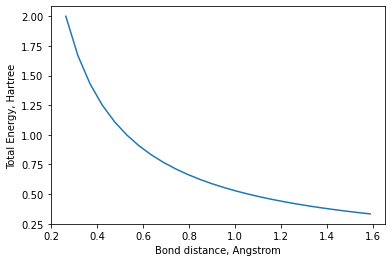

In [17]:
# create many H2 molecules
distances = [round(i*0.1,3) for i in range(5,31)]
molecule_coordinates = [ [[0.0,0.0,0.0], [0.0,0.0, distance]] for distance in distances]
total_energies = []
for molecule_coordinate in molecule_coordinates:

    # creating H2 molecule with STO-3G basis for 1s orbital on hydrogen 
                                # Alpha,           # coeff            # Coord   # angular momentum
    H1_pg1a = primitive_gaussian (0.3425250914E+01, 0.1543289673E+00, molecule_coordinate[0], 0, 0, 0)
    H1_pg1b = primitive_gaussian (0.6239137298E+00 , 0.5353281423E+00, molecule_coordinate[0], 0, 0, 0)
    H1_pg1c = primitive_gaussian (0.1688554040E+00, 0.4446345422E+00, molecule_coordinate[0], 0, 0, 0)

    H2_pg1a = primitive_gaussian (0.3425250914E+01, 0.1543289673E+00, molecule_coordinate[1], 0, 0, 0)
    H2_pg1b = primitive_gaussian (0.6239137298E+00 , 0.5353281423E+00, molecule_coordinate[1], 0, 0, 0)
    H2_pg1c = primitive_gaussian (0.1688554040E+00, 0.4446345422E+00, molecule_coordinate[1], 0, 0, 0)
    
    number_occupied_orbitals = 1.0
    H1_1s = [H1_pg1a, H1_pg1b, H1_pg1c]  # Describing the atomic orbital with slater function
    H2_1s = [H2_pg1a, H2_pg1b, H2_pg1c]

    zlist = [1.0, 1.0]
    atom_coordinates = [np.array(molecule_coordinate[0]), np.array(molecule_coordinate[1])]
    molecule = [H1_1s, H2_1s]
    
    # compute scf energy (electronic energy)
    
    S = overlap (molecule)
    T = kinetic(molecule)
    Vne = electron_nuclear_attraction(molecule, atom_coordinates, zlist)
    Vee = electron_electron_repulsion(molecule)
    Enn = nuclear_nuclear_repulsion_energy(atom_coordinates, zlist)
    molecular_terms = S, T, Vne, Vee
    scf_parameters = [1e-5, 20]
    electronic_energy = scf_cycle(molecular_terms, scf_parameters )
    total_energy = electronic_energy + Enn
    total_energies.append(total_energy)

#plotting bond disscociation curve
plt.xlabel("Bond distance, Angstrom")
plt.ylabel("Total Energy, Hartree")    
plt.plot(np.array(distances)*0.529, total_energies)
